In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

In [2]:
import glob

import numpy as np
import pandas as pd

# function used to read the action files
def get_rows_for_file(file):
    data = np.load(file)
    nb_frames, nb_points, nb_values = data.shape

    res = np.empty((nb_frames, nb_points * nb_values + 1))

    # set features
    res[:,:-1] = data.reshape((nb_frames, nb_points * nb_values))

    # set labels
    parts = file.split('-')
    action_idx = int(parts[1])
    res[:,-1] = action_idx

    return res

In [4]:
# don't forget to change the files path
files = 'actions/*.npy';
Xy = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files)])
Xy.shape

# 54 features, the last column is for the label of each action

(182700, 55)

#### Check to see if the data is balanced

In [5]:
df = pd.DataFrame(Xy)

df.groupby([54]).size()

54
0.0    26100
1.0    26100
2.0    26100
3.0    26100
4.0    26100
5.0    26100
6.0    26100
dtype: int64

We can see in the output from above that the data is balanced. Every action has the same amount of data points.

#### Compute the ranges of every feature 

In [6]:
(pd.concat([df.min(), df.max()], axis=1).rename(columns={0:"min", 1:"max"})).transpose()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
min,-80.000000,0.439392,0.092422,-34.166667,22.480475,0.076566,-4.078280,25.186407,0.089867,5.534295,...,-80.000000,-56.138519,0.077887,-80.000000,0.439392,0.116977,-80.000000,-54.953247,0.073645,0.0
max,666.584843,449.350948,1.117455,717.916667,392.957605,1.006780,717.916667,398.835165,1.013592,717.916667,...,659.199667,532.954766,1.151310,652.732093,531.298228,1.118400,659.418871,532.954766,1.151565,6.0


## Split the data

In [8]:
# don't forget to change the files path
files = 'actions/*group-[1-9]*.npy';
files_2 = 'actions/*group-1[0-6]*.npy';
Xy = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files)])
Xy_2 = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files_2)])

Xy = np.concatenate([Xy,Xy_2])
files_test = 'actions/*group-1[7-9]*.npy';
files_test_2 = 'actions/*group-20*.npy';
Xy_test = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files_test)])
Xy_test_2 = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files_test_2)])

Xy_test = np.concatenate([Xy_test,Xy_test_2])
Xy.shape, Xy_test.shape

# 54 features, the last column is the label of each action

((245700, 55), (37800, 55))

We split the data using a 16-4 split, 80% for training and 20% test data, by splitting on the groups we ensure every frame from a single recording is present in the same partition.

## Preprocessing

In [9]:
X = Xy[:, :-1]
y = Xy[:, -1]

## Machine learning algorithms, hyperparameters choice and training

##### Logistic Regression
Logistic regression belongs to the family of linear models and is specifically used for  classification tasks. It is a type of supervised learning algorithm that models the probability of a binary outcome based on one or more predictor variables. While traditionally used for binary outcomes, it can be extended to multiclass classification problems

Logistic regression is easy to implement and interpret and it is quick to train. It works very well when the relationship between the features and the class labels is approximately linear. 

The main problem is that this algorithm assumes a linear relationship between the input features and the odds of the outcome. This can limit its effectiveness if the true relationship is non linear.  The model is also sensitive to outliers, wich can distort the estimation of the regression coefficients.

##### Random Forest
Random Forest is an ensemble learning method that belongs to the family of decision tree algorithms. Specifically, it is a type of bagging method that combines the predictions from multiple decision trees to improve accuracy and control overfitting. It falls under the category of supervised learning, primarily used for classification and regression tasks.

Because the model averages the results of many trees it is very robust. The model is also capable of handling a large number of  features without feature selection, making it suitable for complex datasets. On top of that the model provides insights into feature importance, helping to understand which features are most influential in predictions.

There are also a couple of disadvantages: longer training time than other algorithms within the family and a lot of memory usage due to the storage of multiple trees. Both of these will be a concern with large datasets.

##### Gaussian Naive Bayes
The Gaussian Naive Bayes method is a supervised learning algorithm based on applying Bayes’ theorem and is popular for classification tasks. It is termed "naive" because it assumes that the features used for prediction are conditionally independent given the class label.

This algorithm works well with high-dimensional data, so it should perform decently well even though there are a lot of features given the amount of examples.

Another positive aspect of this algorithm is that it is said to perform well with limited data.

The two main disadvantages are the fact that it is assumed that features are independent, which is not the case here. Aso the model may not capture complex relationships in the data due to its simplistic approach.

### Training an SVM

Preparing the test data

In [10]:
X_test = Xy_test[:, :-1]
y_test = Xy_test[:, -1]

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


pipeline = make_pipeline(StandardScaler(), LinearSVC(random_state=42))

param_grid = {
    'linearsvc__max_iter': [100, 200, 500, 1000, 2000, 5000],
    'linearsvc__C': [0.01, 0.1, 1, 10, 100]
}

clf = GridSearchCV(pipeline, param_grid, cv=5)

clf.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best Cross-Validation Score:", clf.best_score_)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.7450529100529101

We can see that using StandardScaler to Standardize the data the classifier makes better predictions on the test data. When using minmax normalization, the classifier performd way worse because an SVM uses distance calculations. If a feature is compressed using minmax scaling, it influences the calculation of the gradient, reducing the performance.

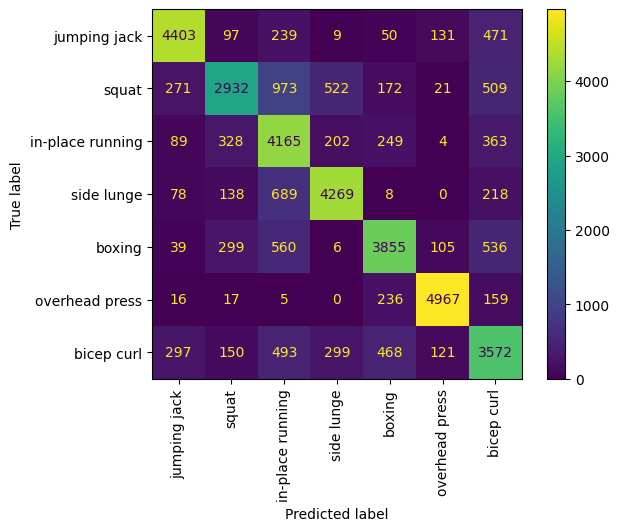

In [13]:
labels = [
    'jumping jack',
    'squat',
    'in-place running',
    'side lunge',
    'boxing',
    'overhead press',
    'bicep curl'
]

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf,X_test,y_test,display_labels=labels, xticks_rotation='vertical')

plt.show()



In-place running and squat are the actions most confused, we think that is because those movements look alike because the legs are in a 90 degrees position. 
The overhead press is the distinctively different from the others because it is the only one with the arm straight above the head.

### Training the classifier using Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {
    'logisticregression__max_iter': [100, 200, 500, 1000, 2000, 5000],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

# max_iter sets the maximum number of iterations 
# taken for the solvers to converge

# C controls the regularization strength. 
# smaller values specifiy stronger regularization.

clf = GridSearchCV(pipeline, param_grid, cv=5)

clf.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best Cross-Validation Score:", clf.best_score_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [15]:
# predict the labels for the test data
_y_test = clf.predict(X_test)

accuracy_score(y_test,_y_test)

0.7576719576719577

### Training the classifier using RandomForest

In [23]:
from sklearn.ensemble import RandomForestClassifier


pipeline = make_pipeline(RandomForestClassifier(max_depth=2, random_state=0))

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100,200,300],
    'randomforestclassifier__max_depth': [2,5,10, None]
}

# n_estimators controls the number of trees in the forest,
# more trees improve performance, but also increase computation time

# max_depth is used for the maximum depth of each tree.
# smaller depth can help avoiding overfitting for small datasets.

clf = GridSearchCV(pipeline, param_grid, cv=5)

clf.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best Cross-Validation Score:", clf.best_score_)

RandomForestClassifier(max_depth=2, random_state=0)

Decision trees are unaffected by the range of values so Random forests are insensitive to scaling or standardization, so it is useless to scale or standardize the data.

In [24]:
# predict the labels for the test data
_y_test = clf.predict(X_test)

accuracy_score(y_test,_y_test)

0.576957671957672

### Training the classifier using Gaussian Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
pipeline = make_pipeline(GaussianNB())

param_grid = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Smoothing parameter
}

# adds a small value to the variance to prevent zero variance, 
# this helps to stabilize the model when data contains very small variances


gnb = GridSearchCV(pipeline, param_grid, cv=5)

gnb.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best Cross-Validation Score:", clf.best_score_)

GaussianNB()

In [26]:
# predict the labels for the test data
_y_test = gnb.predict(X_test)

accuracy_score(y_test,_y_test)

0.576058201058201